# Simple Graph Neural Networks for Velocity Domain Transfer
---
> Graph neural network model for vertex dynamics and tension prediction

- All simulated movies, regardless of their simulation param-s, use the same *normalisation constants*.
- Hara movies (node velocity data) and ablation (recoil data) movies have different spatio-temporal resolutions:
    - After scaling them to the same length scale and frame rate (microns/10s), we use the average edge length to normalise spatial variables (displacement and position; frame rate is assumed to be 10s for all movies including the simulated movies)

|Dataset | Details | Shortname| Avg. edge len.| Transforms (Normalisation)|
|:---:|:---|:---|---:|:---|
|Synthetic datasets     | vertex dynamics simulations| "train" and "val"| 1.0 a.u.| `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)`, `ScalePressure(0.33,shift=0.1)]`|
|Hara movies    | no force information       | "hara"| 26.32 pixels|`[Pos2Vec(scale=10*26.32)`,`ScaleVelocity(0.5*26.32)]`|
|Hara ablation | short movies w/ recoil data| "abln"| 26.32*0.4/0.21 pixels | (not used for testing velocity) |


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use(['seaborn-paper', 'seaborn-ticks'])
# import seaborn as sns
# sns.set_theme(context='paper', style='ticks')

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
# matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies
from simgnn.train import train_model, write_log, load_log, predict, predict_batch
from simgnn.train import plot_velocity_predictions, plot_losses
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure, Reshape_x
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Datasets

`CellData` prop-s (graph data objects):
- `x` : `(#nodes, WindowWidth, 2)` *node features*
- `y` : `(#nodes, 2)` *node targets (velocities)*.
- `pos` : `(#nodes, 2)` *node positions*.
- `edge_attr` : `(#edges, 2)` or `(#edges, #edge_features)` *edge features  (relative Cartesian positions of connected nodes)*.
- `edge_index` : `(2, #edges)` *edge indices*.
- `edge_tensions` : `(#edges,)` *edge targets (line tensions)*.
- `node2cell_index` : `(2, #cell2node_edges)`, `node2cell`-> *first row is node indices and second row is cell indices;
- `cell2node_index` : `(2, #cell2node_edges)`, `cell2node`-> *first row is cell indices and second row is node indices*.
- `cell_pressures` : `(#cells,)` *cell targets (cell pressures)*.

In [5]:
!rm -dr simgnn_data/single_distr_sims/train/processed
# !rm -dr simgnn_data/single_distr_sims/val/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed
!rm -dr simgnn_data/hara_movies/processed

In [6]:
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed/
!rm -dr simgnn_data/hara_movies/processed/

rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/': No such file or directory
rm: cannot remove 'simgnn_data/unimodal_wbasetens_sims/val/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies/processed/': No such file or directory


- Average lengths

In [7]:
window_size = 5

In [8]:
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

In [9]:
# Normalisation: for simulated data (simul params ~ normal distr-s): l0=1.0, Hara_movie: l0=26.32
# Tnorm = T.Compose([Pos2Vec(scale=1.0*10.0) , ScaleVelocity(1.0*0.5), Reshape_x((-1,window_size*2)) ] )
# Hara movie normalisation
# Tnorm_hara = T.Compose([Pos2Vec(scale=10*26.32) , ScaleVelocity(0.5*26.32), Reshape_x((-1,window_size*2))])

# Use mean edge len w/o additional scaling for vel-y and edge len-s
Tnorms = {k : T.Compose([Pos2Vec(scale=l_0[k]) , ScaleVelocity(l_0[k]), Reshape_x((-1,window_size*2)) ] )
          for k in ['sim', 'hara']
         }

velocity_scale = {'train':l_0['sim'], 'val':l_0['sim'], 'val2':l_0['sim'], 'hara':l_0['hara']}

In [10]:
# Hara movie datasets
# seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorms['hara'])
# seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size,
#                     transform=Tnorms['hara'],smoothing=True, sma_lag_time=4)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size,
#                     transform=Tnorms['hara'],smoothing=True, sma_lag_time=4)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size,
#                     transform=Tnorms['hara'],smoothing=True, sma_lag_time=4)

hara = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorms['hara'], smoothing=True, sma_lag_time=4)


# Simulation datasets
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size, transform=Tnorms['sim'])
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size, transform=Tnorms['sim'])
sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size, transform=Tnorms['sim'])
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size, transform=Tnorms['sim'])

datasets_dict = {'train': sim1,
                 'val': sim1_val,
                 'val2' : sim2_val,
                 'hara' : hara,
#                  'early' : seg001[-5:],
#                  'mid'   : seg003[-5:],
#                  'late'  : seg005[-5:],
#                 'raw': seg001_raw[len(seg001_raw)//3-1-5:len(seg001_raw)//3-1]
                }
dataset_legend={'train': 'Train(sim1)',
                'val': 'Val(sim1)',
                'val2': 'Sim2Sim',
                'hara': 'Hara',
               'early': 'Hara(early)',
                'mid': 'Hara(mid)',
                'late': 'Hara(late)',
               'raw': 'Hara(early:raw)'}

# datasets_dict = {'train': sim1,
#                  'val': sim2,
#                  'early' : seg001[-5:],
#                  'mid'   : seg003[-5:],
#                  'late'  : seg005[-5:]}
# dataset_legend={'train': 'Train (sim1)',
#                 'val': 'Val(sim2)',
#                 'early': 'Hara (early)',
#                 'mid': 'Hara(mid)',
#                 'late': 'Hara(late)'}

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [11]:
# k='train'
# print('{} : {}\nsize:{}\n\nFrame 1:\n{}'.format(k,datasets_dict[k],len(datasets_dict[k]),datasets_dict[k][0]))
# plt.figure(figsize=[2.5,2.5])
# nx.draw(to_networkx(datasets_dict[k][0]),pos=dict(enumerate(datasets_dict[k][0].pos.numpy())), node_size=10)

### Helper functions

In [24]:
# def plot_losses(train_log, loaders, dataset_legend,figsize=[7,4]):
#     if figsize is not None:
#         plt.figure(figsize=figsize)
#     training_epochs = np.arange(train_log['total_epochs'])
#     for data_name in loaders:
#         plt.plot(training_epochs, train_log[f'{data_name}_loss_tot'],lw=3,label=f'{dataset_legend[data_name]}')
#     plt.legend();


# def plot_velocity_predictions(vel_pred, vel_tgt, dataset_legend, figsize=[7,4]):
#     var_type = 0
#     var_name = '$\Delta{}x$'

#     for data_name in vel_pred:
#         minY, maxY  = torch.cat(vel_tgt[data_name],dim=0).min(), torch.cat(vel_tgt[data_name],dim=0).max()

#         fig,axs = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=figsize)    
#         for k,ax in enumerate(axs):
#             ax.plot(torch.cat(vel_tgt[data_name], dim=0)[:,k],
#                     torch.cat(vel_pred[data_name], dim=0)[:,k], 'o',ms=10,mfc='tomato',alpha=.25)
#             ax.plot([minY,maxY], [minY,maxY],'--',color='b',lw=2,alpha=.5)
#             ax.set_xlabel('True');
#             ax.set_ylabel('Predicted')
#             ax.set_title(f'{var_name}$_{k}$');
#         plt.suptitle(f'{dataset_legend[data_name]}')
#         plt.show()

### Persistence Loss

In [135]:
# print('Persistence:')
# for k in datasets_dict:
#     print(f'\t- {dataset_legend[k]}: {persistence_loss(datasets_dict[k])}')

# len(datasets_dict['train'])

## Plain MLP
> y=MLP(x) models (no graph), uses single node trends to predict trajectory

- Train `sim1` dataset domain and transfer model to `sim2`.

In [15]:
from simgnn.models import Plain_MLP

In [17]:
dropout_p = 0
num_epochs = 20
lr = 0.001

bs = 2

loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val': DataLoader(datasets_dict['val'], batch_size=bs),
           'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
#           'hara': DataLoader(datasets_dict['hara'], batch_size=bs)
          }

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

loss_func = torch.nn.MSELoss(reduction='mean')
# loss_func = torch.nn.L1Loss(reduction='mean')

save_dir = './simgnn_data/saved_models/thesis/velocity_MLP_sim2sim/'

- MLPs with different sizes (n_hidden layers)

0: N(h_dims)=2
Plain_MLP_h2_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=0.005411; train_loss_y=0.005411; |val_loss_tot=0.0007102; |val2_loss_tot=0.0008912; |7s
Epoch 1/19: train_loss_tot=0.0005607; train_loss_y=0.0005607; |val_loss_tot=0.0003546; |val2_loss_tot=0.0005203; |10s
Epoch 2/19: train_loss_tot=0.0003702; train_loss_y=0.0003702; |val_loss_tot=0.0002909; |val2_loss_tot=0.0004459; |13s
Epoch 3/19: train_loss_tot=0.000333; train_loss_y=0.000333; |val_loss_tot=0.0002744; |val2_loss_tot=0.0004265; |16s
Epoch 4/19: train_loss_tot=0.0003181; train_loss_y=0.0003181; |val_loss_tot=0.0002663; |val2_loss_tot=0.0004107; |19s
Epoch 5/19: train_loss_tot=0.0003074; train_loss_y=0.0003074; |val_loss_tot=0.000271; |val2_loss_tot=0.0004102; |22s
Epoch 6/19: train_loss_tot=0.0003009; train_loss_y=0.0003009; |val_loss_tot=0.0002553; |val2_loss_tot=0.0003981; |24s
Epoch 7/19: train_loss_tot=0.00

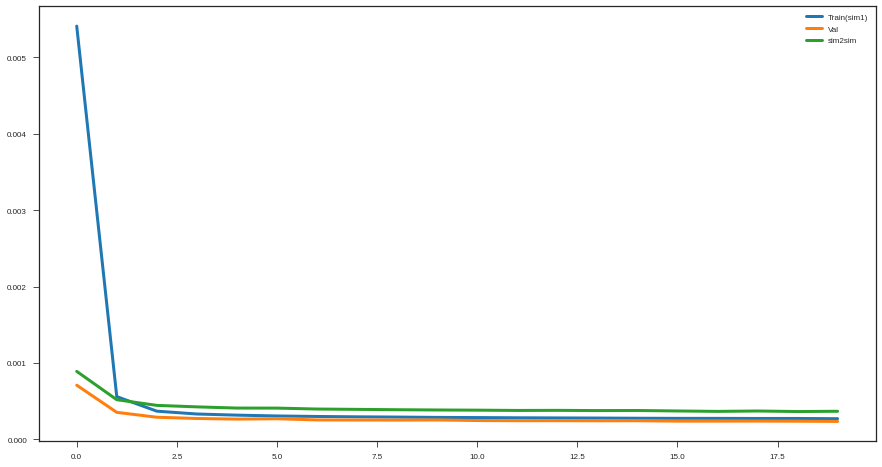

Model weights saved in 
./simgnn_data/saved_models/thesis/velocity_MLP_sim2sim/Plain_MLP_h2_dp0bs2w5.pkl
1: N(h_dims)=4
Plain_MLP_h4_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=0.006961; train_loss_y=0.006961; |val_loss_tot=0.0005777; |val2_loss_tot=0.0007555; |3s
Epoch 1/19: train_loss_tot=0.0005086; train_loss_y=0.0005086; |val_loss_tot=0.0003454; |val2_loss_tot=0.0005088; |6s
Epoch 2/19: train_loss_tot=0.0003627; train_loss_y=0.0003627; |val_loss_tot=0.0002894; |val2_loss_tot=0.0004416; |9s
Epoch 3/19: train_loss_tot=0.0003275; train_loss_y=0.0003275; |val_loss_tot=0.0002745; |val2_loss_tot=0.0004229; |11s
Epoch 4/19: train_loss_tot=0.0003127; train_loss_y=0.0003127; |val_loss_tot=0.0002654; |val2_loss_tot=0.0004111; |14s
Epoch 5/19: train_loss_tot=0.0003043; train_loss_y=0.0003043; |val_loss_tot=0.000263; |val2_loss_tot=0.0003988; |18s
Epoch 6/19: train_loss_tot=0.0003002; train_

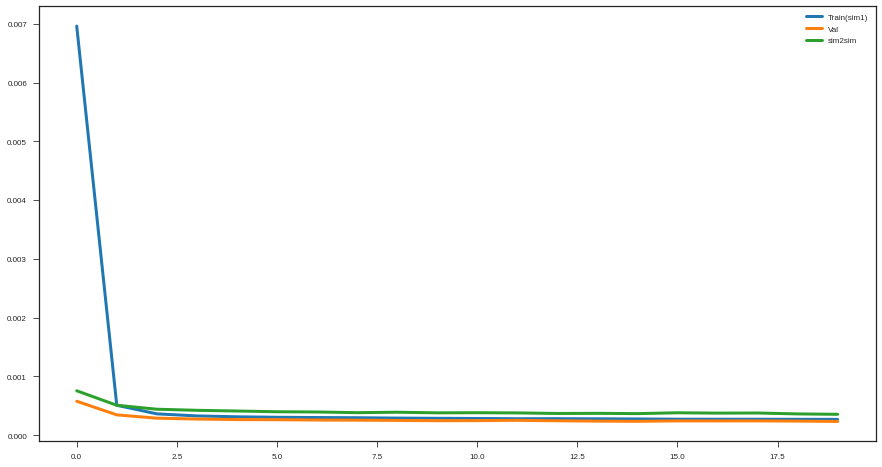

Model weights saved in 
./simgnn_data/saved_models/thesis/velocity_MLP_sim2sim/Plain_MLP_h4_dp0bs2w5.pkl
2: N(h_dims)=6
Plain_MLP_h6_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=  0.0013; train_loss_y=  0.0013; |val_loss_tot=0.0004043; |val2_loss_tot=0.0005505; |3s
Epoch 1/19: train_loss_tot=0.0003765; train_loss_y=0.0003765; |val_loss_tot=0.0002828; |val2_loss_tot=0.0004362; |6s
Epoch 2/19: train_loss_tot=0.0003265; train_loss_y=0.0003265; |val_loss_tot=0.0002728; |val2_loss_tot=0.0004241; |9s
Epoch 3/19: train_loss_tot=0.0003113; train_loss_y=0.0003113; |val_loss_tot=0.0002704; |val2_loss_tot=0.0004175; |12s
Epoch 4/19: train_loss_tot=0.0003064; train_loss_y=0.0003064; |val_loss_tot=0.0002606; |val2_loss_tot=0.0004027; |16s
Epoch 5/19: train_loss_tot=0.0003051; train_loss_y=0.0003051; |val_loss_tot=0.0002756; |val2_loss_tot=0.0004095; |19s
Epoch 6/19: train_loss_tot=0.0003032; train

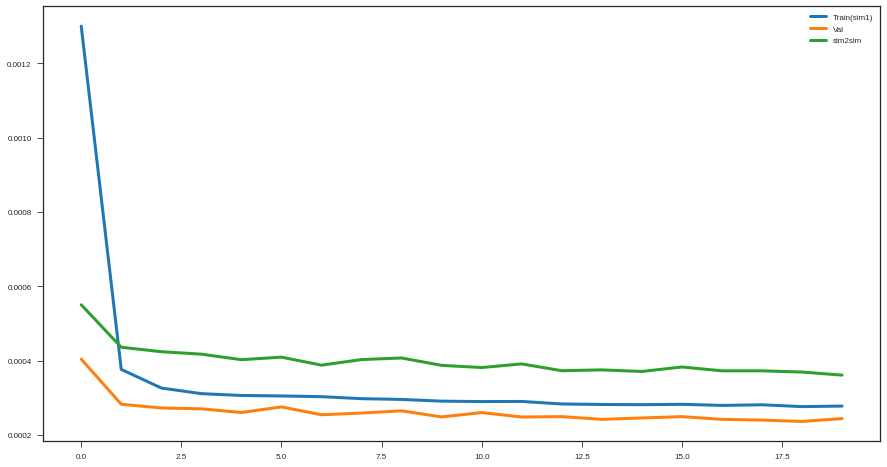

Model weights saved in 
./simgnn_data/saved_models/thesis/velocity_MLP_sim2sim/Plain_MLP_h6_dp0bs2w5.pkl
3: N(h_dims)=8
Plain_MLP_h8_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=0.002526; train_loss_y=0.002526; |val_loss_tot=0.001191; |val2_loss_tot=0.001288; |3s
Epoch 1/19: train_loss_tot=0.001081; train_loss_y=0.001081; |val_loss_tot=0.000456; |val2_loss_tot=0.0006005; |6s
Epoch 2/19: train_loss_tot=0.0003834; train_loss_y=0.0003834; |val_loss_tot=0.0002847; |val2_loss_tot=0.0004383; |10s
Epoch 3/19: train_loss_tot=0.0003277; train_loss_y=0.0003277; |val_loss_tot=0.000263; |val2_loss_tot=0.0004033; |13s
Epoch 4/19: train_loss_tot= 0.00031; train_loss_y= 0.00031; |val_loss_tot=0.0002624; |val2_loss_tot=0.0004046; |16s
Epoch 5/19: train_loss_tot=0.0003038; train_loss_y=0.0003038; |val_loss_tot=0.0002632; |val2_loss_tot=0.0004022; |20s
Epoch 6/19: train_loss_tot=0.0003023; train_loss_y

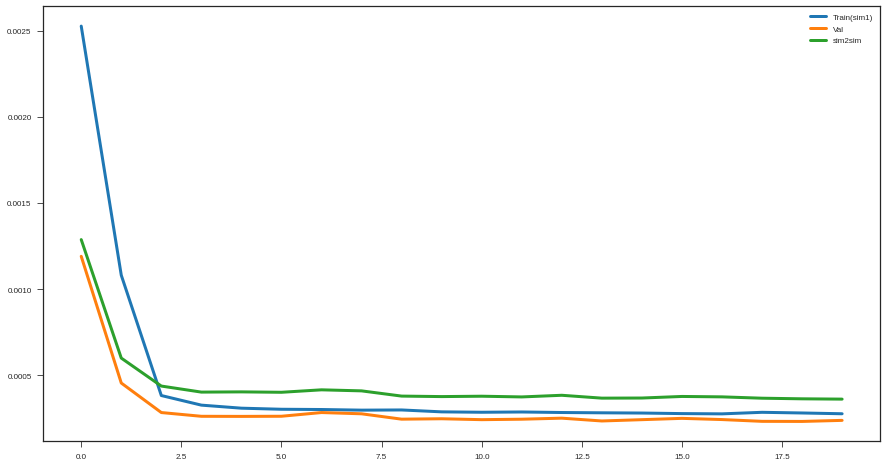

Model weights saved in 
./simgnn_data/saved_models/thesis/velocity_MLP_sim2sim/Plain_MLP_h8_dp0bs2w5.pkl
4: N(h_dims)=10
Plain_MLP_h10_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=0.003433; train_loss_y=0.003433; |val_loss_tot=0.001505; |val2_loss_tot=0.001659; |3s
Epoch 1/19: train_loss_tot=0.001395; train_loss_y=0.001395; |val_loss_tot=0.001085; |val2_loss_tot=0.001266; |7s
Epoch 2/19: train_loss_tot=0.0007083; train_loss_y=0.0007083; |val_loss_tot=0.0003114; |val2_loss_tot=0.0004721; |10s
Epoch 3/19: train_loss_tot=0.0003427; train_loss_y=0.0003427; |val_loss_tot=0.0002759; |val2_loss_tot=0.0004317; |13s
Epoch 4/19: train_loss_tot=0.0003287; train_loss_y=0.0003287; |val_loss_tot=0.0002801; |val2_loss_tot=0.0004198; |17s
Epoch 5/19: train_loss_tot=0.0003175; train_loss_y=0.0003175; |val_loss_tot=0.0002892; |val2_loss_tot=0.0004269; |20s
Epoch 6/19: train_loss_tot=0.0003069; train_lo

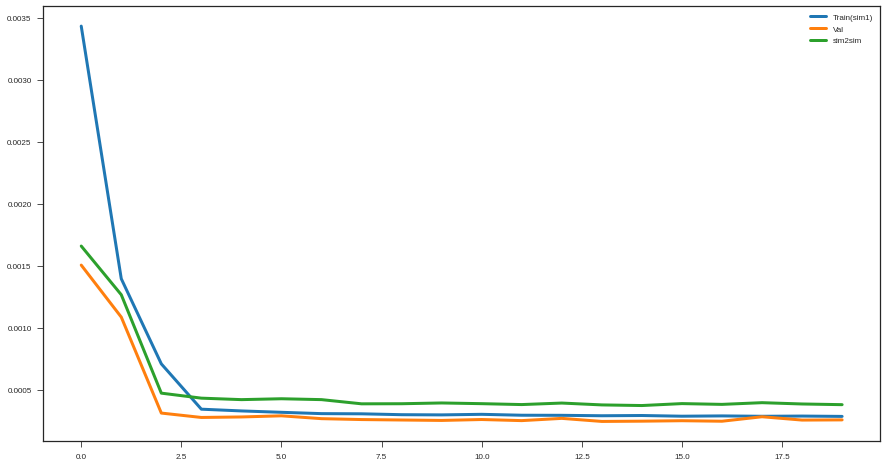

Model weights saved in 
./simgnn_data/saved_models/thesis/velocity_MLP_sim2sim/Plain_MLP_h10_dp0bs2w5.pkl


In [19]:
Hidden_dims = [[128 for lk in range(num_layers)]+[16] for num_layers in range(1,10,2)]

for k, h_dims in enumerate(Hidden_dims):
    torch.manual_seed(k)
    
    print(f'{k}: N(h_dims)={len(h_dims)}')
    
    net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=h_dims, dropout_p=dropout_p).to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    # opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

    return_best = False
    model_name = f'{net.__class__.__name__}_h{len(h_dims)}_dp{dropout_p}bs{bs}w{window_size}'
    
    print(model_name,end='\n---\n')
    net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=None, device=device,
                                 model_states = model_states, loss_func = loss_func,
                                 use_force_loss=use_force_loss, return_best=return_best)
    
    # plot losses
    plot_losses(train_log, loaders, dataset_legend, figsize=[7,4]); plt.show()
    
    write_log(f'{path.join(save_dir, model_name)}_log.pkl',train_log)
    model_save_path = path.join(save_dir, model_name+'.pkl')
    torch.save(net.state_dict(), model_save_path)
    print(f'Model weights saved in \n{model_save_path}\n---\n')

---

## Single Message Passing Step
> Single MP step, uses graph and relative node positions w.r.t. connected neighbouring nodes

- Single MP step w/ a very simple Update mlp. Update stage is equivalent to the node model (plain mlp) w/ an additional edge features as messages.

In [161]:
from simgnn.models import Single_MP_step

In [162]:
dropout_p = 0
num_epochs = 20
lr = 0.001

bs = 2

loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val': DataLoader(datasets_dict['val'], batch_size=bs),
           'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
#           'hara': DataLoader(datasets_dict['hara'], batch_size=bs)
          }

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

loss_func = torch.nn.MSELoss(reduction='mean')

save_dir = './simgnn_data/saved_models/thesis/velocity_MP_sim2sim/'

- The output layer of the message MLP in a 1-layer GNN model counted as a hidden layer

0: N(h_dims)=2
Single_MP_step_h2_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=0.002792; train_loss_y=0.002792; |val_loss_tot=0.001091; |val2_loss_tot=0.001331; |3s
Epoch 1/19: train_loss_tot=0.0008562; train_loss_y=0.0008562; |val_loss_tot=0.0005677; |val2_loss_tot=0.0007538; |6s
Epoch 2/19: train_loss_tot=0.0005569; train_loss_y=0.0005569; |val_loss_tot=0.0004102; |val2_loss_tot=0.0005789; |9s
Epoch 3/19: train_loss_tot=0.0004388; train_loss_y=0.0004388; |val_loss_tot=0.0003443; |val2_loss_tot=0.0005052; |12s
Epoch 4/19: train_loss_tot=0.0003865; train_loss_y=0.0003865; |val_loss_tot=0.0003129; |val2_loss_tot=0.000466; |15s
Epoch 5/19: train_loss_tot=0.0003561; train_loss_y=0.0003561; |val_loss_tot=0.0002931; |val2_loss_tot= 0.00044; |18s
Epoch 6/19: train_loss_tot=0.0003357; train_loss_y=0.0003357; |val_loss_tot=0.0002779; |val2_loss_tot=0.0004208; |21s
Epoch 7/19: train_loss_tot=0.

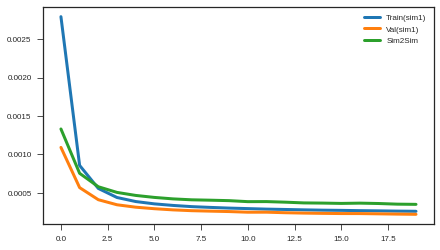

Model weights saved in 
./simgnn_data/saved_models/thesis/velocity_MP_sim2sim/Single_MP_step_h2_dp0bs2w5.pkl
---

1: N(h_dims)=4
Single_MP_step_h4_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot= 0.00284; train_loss_y= 0.00284; |val_loss_tot=0.0006563; |val2_loss_tot=0.0008789; |3s
Epoch 1/19: train_loss_tot=0.0005624; train_loss_y=0.0005624; |val_loss_tot=0.0003711; |val2_loss_tot=0.0005375; |6s
Epoch 2/19: train_loss_tot=0.0003826; train_loss_y=0.0003826; |val_loss_tot=0.000297; |val2_loss_tot=0.0004504; |10s
Epoch 3/19: train_loss_tot=0.0003373; train_loss_y=0.0003373; |val_loss_tot=0.0002736; |val2_loss_tot=0.0004217; |13s
Epoch 4/19: train_loss_tot=0.0003144; train_loss_y=0.0003144; |val_loss_tot=0.0002639; |val2_loss_tot=0.0004124; |16s
Epoch 5/19: train_loss_tot=0.0002982; train_loss_y=0.0002982; |val_loss_tot=0.0002505; |val2_loss_tot=0.0003881; |19s
Epoch 6/19: train_loss_tot=0.

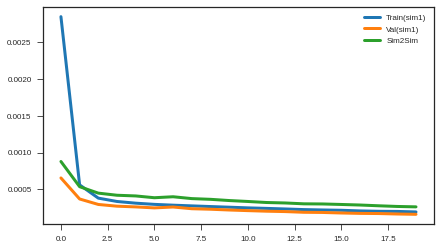

Model weights saved in 
./simgnn_data/saved_models/thesis/velocity_MP_sim2sim/Single_MP_step_h4_dp0bs2w5.pkl
---

2: N(h_dims)=6
Single_MP_step_h6_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=0.001714; train_loss_y=0.001714; |val_loss_tot=0.0005205; |val2_loss_tot=0.0007218; |3s
Epoch 1/19: train_loss_tot=0.0004439; train_loss_y=0.0004439; |val_loss_tot=0.000306; |val2_loss_tot= 0.00046; |6s
Epoch 2/19: train_loss_tot=0.0003376; train_loss_y=0.0003376; |val_loss_tot=0.0002693; |val2_loss_tot=0.0004135; |9s
Epoch 3/19: train_loss_tot=0.0003079; train_loss_y=0.0003079; |val_loss_tot=0.000255; |val2_loss_tot=0.0003958; |12s
Epoch 4/19: train_loss_tot=0.000292; train_loss_y=0.000292; |val_loss_tot=0.0002485; |val2_loss_tot=0.000389; |16s
Epoch 5/19: train_loss_tot=0.0002805; train_loss_y=0.0002805; |val_loss_tot=0.0002391; |val2_loss_tot=0.0003739; |19s
Epoch 6/19: train_loss_tot=0.000272

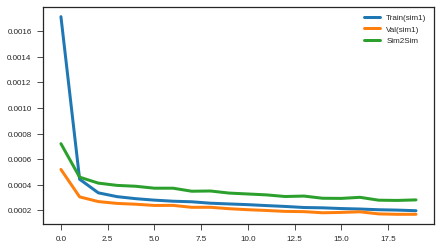

Model weights saved in 
./simgnn_data/saved_models/thesis/velocity_MP_sim2sim/Single_MP_step_h6_dp0bs2w5.pkl
---

3: N(h_dims)=8
Single_MP_step_h8_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=0.002213; train_loss_y=0.002213; |val_loss_tot=0.0004563; |val2_loss_tot=0.0006399; |3s
Epoch 1/19: train_loss_tot=0.0003828; train_loss_y=0.0003828; |val_loss_tot=0.0002875; |val2_loss_tot=0.0004452; |7s
Epoch 2/19: train_loss_tot=0.0003081; train_loss_y=0.0003081; |val_loss_tot=0.0002584; |val2_loss_tot=  0.0004; |10s
Epoch 3/19: train_loss_tot=0.0002894; train_loss_y=0.0002894; |val_loss_tot=0.0002444; |val2_loss_tot=0.0003836; |13s
Epoch 4/19: train_loss_tot=0.0002789; train_loss_y=0.0002789; |val_loss_tot=0.000238; |val2_loss_tot=0.0003698; |17s
Epoch 5/19: train_loss_tot=0.0002664; train_loss_y=0.0002664; |val_loss_tot= 0.00022; |val2_loss_tot=0.0003476; |20s
Epoch 6/19: train_loss_tot=0.00

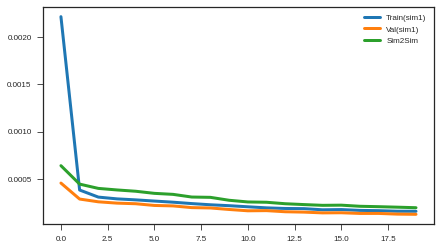

Model weights saved in 
./simgnn_data/saved_models/thesis/velocity_MP_sim2sim/Single_MP_step_h8_dp0bs2w5.pkl
---

4: N(h_dims)=10
Single_MP_step_h10_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=0.004495; train_loss_y=0.004495; |val_loss_tot=0.001241; |val2_loss_tot=0.001436; |3s
Epoch 1/19: train_loss_tot=0.001206; train_loss_y=0.001206; |val_loss_tot=0.0004777; |val2_loss_tot=0.0006641; |7s
Epoch 2/19: train_loss_tot=0.000422; train_loss_y=0.000422; |val_loss_tot=0.0002949; |val2_loss_tot=0.0004558; |10s
Epoch 3/19: train_loss_tot=0.0003384; train_loss_y=0.0003384; |val_loss_tot=0.000271; |val2_loss_tot=0.0004211; |14s
Epoch 4/19: train_loss_tot=0.0003097; train_loss_y=0.0003097; |val_loss_tot=0.0002585; |val2_loss_tot=0.0003971; |17s
Epoch 5/19: train_loss_tot=0.0002937; train_loss_y=0.0002937; |val_loss_tot=0.0002449; |val2_loss_tot=0.0003791; |21s
Epoch 6/19: train_loss_tot=0.0002

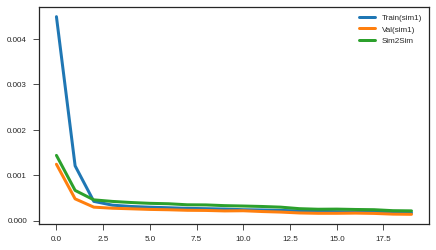

Model weights saved in 
./simgnn_data/saved_models/thesis/velocity_MP_sim2sim/Single_MP_step_h10_dp0bs2w5.pkl
---



In [163]:
tot_hidden_layers = [2, 4, 6, 8, 10]

for k, num_hidden in enumerate(tot_hidden_layers):
    torch.manual_seed(k+42)
    
    msg_dim = 32  # message MLP latent dim-s
    upd_dim = 128  # update MLP latent dim-s
    
    upd_h_layers = max([0, num_hidden//2])# Update MLP hidden_layers
    update_hidden_dims=[upd_dim for k in range(upd_h_layers-1)]+[16]
    
    msg_h_layers = max([0, num_hidden - upd_h_layers])# Message MLP hidden_layers
    message_hidden_dims = [msg_dim for k in range(msg_h_layers-1)] # assume output layer is hidden for MP step model
    
    
    
    print(f'{k}: N(h_dims)={num_hidden}')
    
    net = Single_MP_step(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                         message_out_features=msg_dim, message_hidden_dims=message_hidden_dims,
                         aggr='mean', update_hidden_dims=update_hidden_dims,
                         dropout_p=dropout_p).to(device)
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    # opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    # opt = torch.optim.Adamax(net.parameters(), lr=lr)
    scheduler = None
    # scheduler = torch.optim.lr_scheduler.StepLR(opt, 100

    return_best = False
    model_name = f'{net.__class__.__name__}_h{num_hidden}_dp{dropout_p}bs{bs}w{window_size}'
    
    print(model_name,end='\n---\n')
    net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=None, device=device,
                                 model_states = model_states, loss_func = loss_func,
                                 use_force_loss=use_force_loss, return_best=return_best)
    
    # plot losses
    plot_losses(train_log, loaders, dataset_legend, figsize=[7,4]); plt.show()
    
    write_log(f'{path.join(save_dir, model_name)}_log.pkl',train_log)
    model_save_path = path.join(save_dir, model_name+'.pkl')
    torch.save(net.state_dict(), model_save_path)
    print(f'Model weights saved in \n{model_save_path}\n---\n')

- train_loss_tot =0.00016231347840948312;
- train_loss_y =0.00016231347840948312;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.00013690276408926882;
- val_loss_y =0.00013690276408926882;
- val_loss_T =0.0;
- val_loss_P =0.0;
- val2_loss_tot =0.00021294470729238637;
- val2_loss_y =0.00021294470729238637;
- val2_loss_T =0.0;
- val2_loss_P =0.0;



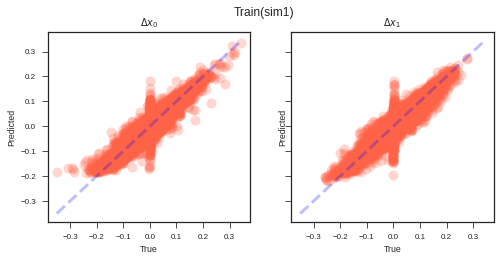

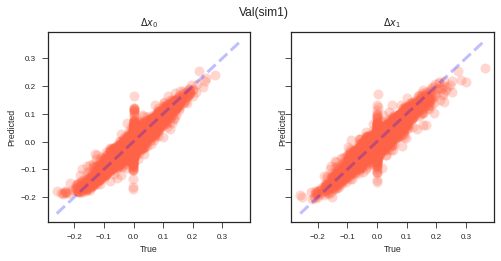

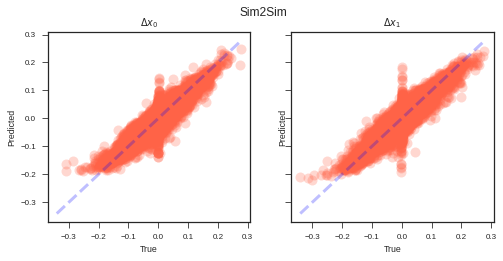

In [164]:
pred_loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val': DataLoader(datasets_dict['val'], batch_size=bs),
           'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
#           'hara': DataLoader(datasets_dict['hara'], batch_size=bs)
          }
# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, pred_loaders,
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {k: False for k in pred_loaders},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend, figsize=[8,3.5])

In [27]:
# # compute predictions and plot them
# pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='sum'),
#                                                  use_force_loss = {k:False for k in loaders}, return_losses = True, device=device)
# print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

# plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [165]:
# write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
# torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
# print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

---

## Load Model and Check Performance

In [23]:
bs = 2
pred_loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val': DataLoader(datasets_dict['val'], batch_size=bs),
           'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
          'hara': DataLoader(datasets_dict['hara'], batch_size=bs)
          }

### MLP

In [157]:
save_dir = './simgnn_data/saved_models/thesis/velocity_MLP_sim2sim/'

hidden_dims_nums = [2, 4, 6, 8, 10]
loss_mlp_h = {'h':hidden_dims_nums,
              'val_loss_y': [],
              'val2_loss_y': []}

for num_layers in hidden_dims_nums:
    h_dims = [128 for lk in range(num_layers-1)]+[16]
    dropout_p = 0

    model_name = f'Plain_MLP_h{len(h_dims)}_dp{dropout_p}bs2w5.pkl'
    print(f'Loading:\n\t{model_name}')

    net = Plain_MLP(in_features=5*2, out_features=2, hidden_dims=h_dims).to(device)
    net_weights_dict = torch.load(path.join(save_dir, model_name), map_location=device)
    net.load_state_dict(net_weights_dict)
    net.eval();

    # compute predictions and plot them
    pred_out, tgt_out, sample_losses = predict_batch(net, pred_loaders,
                                                     loss_func=torch.nn.MSELoss(reduction='sum'),
                                                     use_force_loss = {k: False for k in pred_loaders},
                                                     return_losses = True, device=device)
    print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

    loss_mlp_h['val_loss_y'].append(sample_losses['val_loss_y'])
    loss_mlp_h['val2_loss_y'].append(sample_losses['val2_loss_y'])

Loading:
	Plain_MLP_h2_dp0bs2w5.pkl
- train_loss_tot =0.00026925949834509446;
- train_loss_y =0.00026925949834509446;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.00023580060098173772;
- val_loss_y =0.00023580060098173772;
- val_loss_T =0.0;
- val_loss_P =0.0;
- val2_loss_tot =0.00036874535436083074;
- val2_loss_y =0.00036874535436083074;
- val2_loss_T =0.0;
- val2_loss_P =0.0;

Loading:
	Plain_MLP_h4_dp0bs2w5.pkl
- train_loss_tot =0.00026628711168417556;
- train_loss_y =0.00026628711168417556;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.0002337625357938801;
- val_loss_y =0.0002337625357938801;
- val_loss_T =0.0;
- val_loss_P =0.0;
- val2_loss_tot =0.0003550096142593069;
- val2_loss_y =0.0003550096142593069;
- val2_loss_T =0.0;
- val2_loss_P =0.0;

Loading:
	Plain_MLP_h6_dp0bs2w5.pkl
- train_loss_tot =0.00027970422691934354;
- train_loss_y =0.00027970422691934354;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.00024423118147310626;
- val_loss

In [158]:
import pandas as pd
pd.DataFrame(data=loss_mlp_h)

,h,val_loss_y,val2_loss_y
0,2,0.000236,0.000369
1,4,0.000234,0.000355
2,6,0.000244,0.000361
3,8,0.000239,0.000363
4,10,0.000256,0.000379


	Plain_MLP_h10_dp0bs2w5.pkl


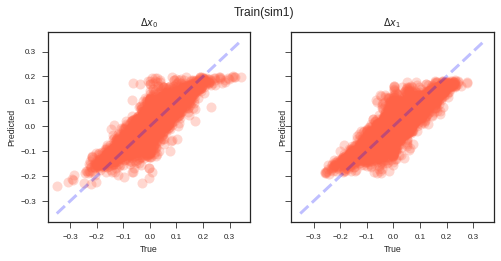

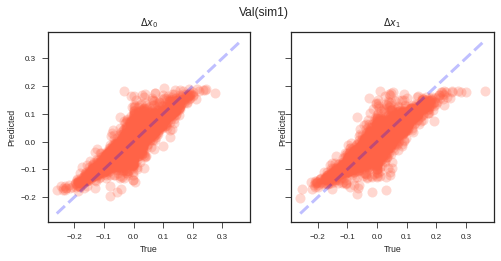

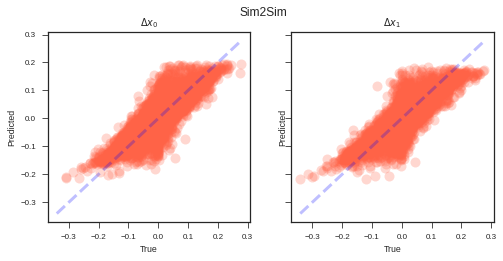

In [131]:
print(f'\t{model_name}')
plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend, figsize=[8,3.5])

### Simple GNN (1-MP layer)

In [13]:
from simgnn.models import Single_MP_step

In [24]:
num_layers = 10
upd_h_layers = max([0, num_layers//2])# Update MLP hidden_layers
update_hidden_dims=[128 for k in range(upd_h_layers-1)]+[16]
msg_h_layers = max([0, num_layers - upd_h_layers])# Message MLP hidden_layers
message_hidden_dims = [32 for k in range(msg_h_layers-1)] # assume output layer is hidden for MP step model

model_name = f'Single_MP_step_h{num_layers}_dp0bs2w5.pkl'
print(f'Loading:\n\t{model_name}')

net = Single_MP_step(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                     message_out_features=32, message_hidden_dims=message_hidden_dims,
                     aggr='mean', update_hidden_dims=update_hidden_dims).to(device)
net_weights_dict = torch.load(path.join(save_dir, model_name), map_location=device)
net.load_state_dict(net_weights_dict)
net.eval();

# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, pred_loaders,
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {k: False for k in pred_loaders},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

Loading:
	Single_MP_step_h10_dp0bs2w5.pkl
- train_loss_tot =0.0001623134774076301;
- train_loss_y =0.0001623134774076301;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.00013690276500472352;
- val_loss_y =0.00013690276500472352;
- val_loss_T =0.0;
- val_loss_P =0.0;
- val2_loss_tot =0.00021294470532424905;
- val2_loss_y =0.00021294470532424905;
- val2_loss_T =0.0;
- val2_loss_P =0.0;
- hara_loss_tot =0.00017618343730986237;
- hara_loss_y =0.00017618343730986237;
- hara_loss_T =0.0;
- hara_loss_P =0.0;



---

In [19]:
save_dir = './simgnn_data/saved_models/thesis/velocity_MP_sim2sim/'

hidden_dims_nums = [2, 4, 6, 8, 10]
loss_mp_h = {'h':hidden_dims_nums,
              'val_loss_y': [],
              'val2_loss_y': []}

for num_layers in hidden_dims_nums:    
    upd_h_layers = max([0, num_layers//2])# Update MLP hidden_layers
    update_hidden_dims=[128 for k in range(upd_h_layers-1)]+[16]
    msg_h_layers = max([0, num_layers - upd_h_layers])# Message MLP hidden_layers
    message_hidden_dims = [32 for k in range(msg_h_layers-1)] # assume output layer is hidden for MP step model
    
    model_name = f'Single_MP_step_h{num_layers}_dp0bs2w5.pkl'
    print(f'Loading:\n\t{model_name}')
    
    net = Single_MP_step(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                         message_out_features=32, message_hidden_dims=message_hidden_dims,
                         aggr='mean', update_hidden_dims=update_hidden_dims).to(device)
    net_weights_dict = torch.load(path.join(save_dir, model_name), map_location=device)
    net.load_state_dict(net_weights_dict)
    net.eval();

    # compute predictions and plot them
    pred_out, tgt_out, sample_losses = predict_batch(net, pred_loaders,
                                                     loss_func=torch.nn.MSELoss(reduction='sum'),
                                                     use_force_loss = {k: False for k in pred_loaders},
                                                     return_losses = True, device=device)
    print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

    loss_mp_h['val_loss_y'].append(sample_losses['val_loss_y'])
    loss_mp_h['val2_loss_y'].append(sample_losses['val2_loss_y'])

Loading:
	Single_MP_step_h2_dp0bs2w5.pkl
- train_loss_tot =0.0002547946559667066;
- train_loss_y =0.0002547946559667066;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.00022015901453924876;
- val_loss_y =0.00022015901453924876;
- val_loss_T =0.0;
- val_loss_P =0.0;
- val2_loss_tot =0.00034967382672295566;
- val2_loss_y =0.00034967382672295566;
- val2_loss_T =0.0;
- val2_loss_P =0.0;

Loading:
	Single_MP_step_h4_dp0bs2w5.pkl
- train_loss_tot =0.0001898285836594236;
- train_loss_y =0.0001898285836594236;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.0001635494807351815;
- val_loss_y =0.0001635494807351815;
- val_loss_T =0.0;
- val_loss_P =0.0;
- val2_loss_tot =0.0002645678556069971;
- val2_loss_y =0.0002645678556069971;
- val2_loss_T =0.0;
- val2_loss_P =0.0;

Loading:
	Single_MP_step_h6_dp0bs2w5.pkl
- train_loss_tot =0.0001962791624192065;
- train_loss_y =0.0001962791624192065;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.0001698442611801847;
- 

In [167]:
import pandas as pd
pd.DataFrame(data=loss_mp_h)

,h,val_loss_y,val2_loss_y
0,2,0.000220,0.000350
1,4,0.000164,0.000265
2,6,0.000170,0.000283
3,8,0.000126,0.000196
4,10,0.000137,0.000213


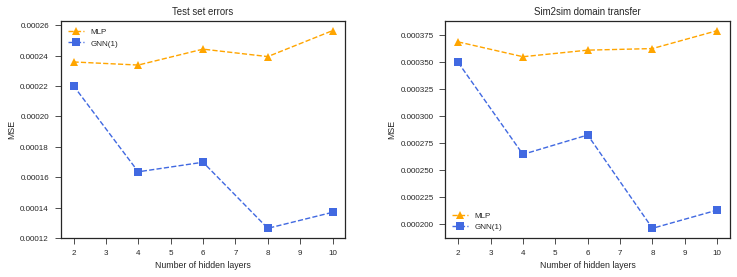

In [185]:
_, axs = plt.subplots(ncols=2, figsize=[12,4], gridspec_kw={'wspace':.35, 'hspace':.25})

for ax, domain_loss in zip(axs.ravel(), [('val_loss_y', 'Test set errors'), ('val2_loss_y', 'Sim2sim domain transfer')]):
    ax.plot('h', domain_loss[0], '^--', data=loss_mlp_h,  ms=8, c='orange', label='MLP')
    ax.plot('h', domain_loss[0], 's--', data=loss_mp_h, ms=8, c='royalblue', label='GNN(1)')
    ax.set_xlabel('Number of hidden layers')
    ax.set_ylabel('MSE')
    ax.legend();
    ax.set_title(domain_loss[1])
# plt.savefig('MLP_and_smallGNN.png', dpi=150)

## Movie Predictions

In [38]:
dataset_mov_names = {}
dataset_mov_idx = {}
dataset_mov = {}

for dataset_k in ['val', 'val2']: #  ['train', 'val', 'val2', 'hara']:
    print(dataset_k)

    d_names_list = [k.split('_')[2] for k in datasets_dict[dataset_k].processed_file_names]
    
    dataset_mov_names[dataset_k] = {k : ki for ki, k in enumerate(np.unique(d_names_list))}
    
    dataset_mov_idx[dataset_k] = torch.tensor([dataset_mov_names[dataset_k][k] for k in d_names_list])
    
    dataset_mov[dataset_k] = {k:datasets_dict[dataset_k][dataset_mov_names[dataset_k][k]==dataset_mov_idx[dataset_k]]
                              for k in dataset_mov_names[dataset_k]}
dataset_mov

val
val2


{'val': {'sim005': VertexDynamics(56), 'sim006': VertexDynamics(56)},
 'val2': {'sim005': VertexDynamics(56), 'sim006': VertexDynamics(56)}}

- **Model Predictions for Movies**; Predict `Velocity[T+1]` for movies

In [27]:
from simgnn.train import np_loss_wrt_time, predict_dataset

from scipy.stats import pearsonr

In [28]:
velocity_scale

{'train': 1.0, 'val': 1.0, 'val2': 1.0, 'hara': 26.32}

In [29]:
ignore_short_edges, edge_len_threshold = False, 10**-4

In [43]:
model_results = {}
loss_type = 'mse'

for dataset_k in dataset_mov:
    print('-'*10+'\n'+dataset_k)
    model_results[dataset_k] = {}
    for mov_i in dataset_mov[dataset_k]:
        if None != dataset_mov[dataset_k][mov_i][0].edge_id:
            num_edges = torch.unique(dataset_mov[dataset_k][mov_i][0].edge_id).size(0)
        else:
            num_edges = dataset_mov[dataset_k][mov_i][0].num_edges
        print('\t',mov_i,f': len={len(dataset_mov[dataset_k][mov_i])};',
              f'E_n={num_edges};',
              f'V_n={dataset_mov[dataset_k][mov_i][0].num_nodes};',
              f'C_n={dataset_mov[dataset_k][mov_i][0].num_cells};', end=' ')

        model_results[dataset_k][mov_i] = predict_dataset(net, dataset_mov[dataset_k][mov_i],device=device, concat=True)


        # Edge indices
        if None != dataset_mov[dataset_k][mov_i][0].edge_id:
            edge_index = dataset_mov[dataset_k][mov_i][0].edge_index[:,torch.unique(dataset_mov[dataset_k][mov_i][0].edge_id)]
        else:
            edge_index = dataset_mov[dataset_k][mov_i][0].edge_index

        model_results[dataset_k][mov_i]['edge_index'] = edge_index
        
        # Vertex pos [targets]
        pos = np.concatenate([d.pos.reshape(1,-1,2) for d in dataset_mov[dataset_k][mov_i]],axis=0)
        model_results[dataset_k][mov_i]['targets']['pos'] = pos
        
        # Edge lengths [targets]
        edge_lengths = np.linalg.norm(pos[:, edge_index[1],:] - pos[:, edge_index[0],:], axis=-1)
        model_results[dataset_k][mov_i]['targets']['edge_lengths'] = edge_lengths
        
        # Compute predicted vertex pos, edge lengths
        dx_unnorm = velocity_scale[dataset_k]*model_results[dataset_k][mov_i]['predictions']['velocity']
        # pos predictions w/ velocity (except for first pos)
        pos_preds = np.concatenate([pos[:1],(pos+dx_unnorm)[:-1]], axis=0)
        model_results[dataset_k][mov_i]['predictions']['pos'] = pos_preds

        model_results[dataset_k][mov_i]['predictions']['edge_lengths'] = np.linalg.norm(pos_preds[:, edge_index[1],:] - pos_preds[:, edge_index[0],:], axis=-1)
        if ignore_short_edges:
            edge_mask = np.all(np.concatenate([dk.edge_length.numpy().reshape(1,-1)
                                               for dk in dataset_mov[dataset_k][mov_i]], axis=0) > edge_len_threshold, axis=0)
            model_results[dataset_k][mov_i]['predictions']['edge_masks'] = edge_mask
        else:
            model_results[dataset_k][mov_i]['predictions']['edge_masks'] = None
        
        model_results[dataset_k][mov_i]['loss'] = {}
        
        # velocity losses
        if len(model_results[dataset_k][mov_i]['targets']['velocity']) > 0:
            model_results[dataset_k][mov_i]['loss']['velocity'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['velocity'],
                                                                                   model_results[dataset_k][mov_i]['targets']['velocity'])
        else:
            model_results[dataset_k][mov_i]['loss']['velocity'] = np.full((model_results[dataset_k][mov_i]['predictions']['velocity'].shape[1],), np.nan)
        
#         # tension losses
#         if len(model_results[dataset_k][mov_i]['targets']['tension']) > 0:
#             model_results[dataset_k][mov_i]['loss']['tension'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['tension'],
#                                                                                   model_results[dataset_k][mov_i]['targets']['tension'])
#         else:
#             model_results[dataset_k][mov_i]['loss']['tension'] = np.full((model_results[dataset_k][mov_i]['predictions']['tension'].shape[1],), np.nan)

#         if ignore_short_edges:
#             model_results[dataset_k][mov_i]['loss']['tension_mask'] = model_results[dataset_k][mov_i]['loss']['tension'].copy()
#             model_results[dataset_k][mov_i]['loss']['tension_mask'][~edge_mask] = np.nan
#         else:
#             model_results[dataset_k][mov_i]['loss']['tension_mask'] = None
        model_results[dataset_k][mov_i]['loss']['edge_lengths'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['edge_lengths'],
                                                                                   model_results[dataset_k][mov_i]['targets']['edge_lengths'])
        
        print(f"Losses: Vel-y={np.nanmean(model_results[dataset_k][mov_i]['loss']['velocity']):6.4f}; "+
              f"E_len={np.nanmean(model_results[dataset_k][mov_i]['loss']['edge_lengths']):6.4f}; "+
#               f"Tension={np.nanmean(model_results[dataset_k][mov_i]['loss']['tension']):6.4f};"+
             f"Tension(mask)={np.nanmean(model_results[dataset_k][mov_i]['loss']['tension_mask']) if ignore_short_edges else 0.0:6.4f}")

----------
val
	 sim005 : len=56; E_n=339; V_n=240; C_n=100; Losses: Vel-y=0.0005; E_len=0.0007; Tension(mask)=0.0000
	 sim006 : len=56; E_n=275; V_n=196; C_n=80; Losses: Vel-y=0.0006; E_len=0.0008; Tension(mask)=0.0000
----------
val2
	 sim005 : len=56; E_n=431; V_n=304; C_n=128; Losses: Vel-y=0.0008; E_len=0.0014; Tension(mask)=0.0000
	 sim006 : len=56; E_n=531; V_n=372; C_n=160; Losses: Vel-y=0.0007; E_len=0.0011; Tension(mask)=0.0000


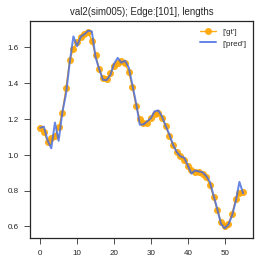

In [79]:
dataset_k, mov_i = 'val2', 'sim005'  # ['val2']['sim005']

# Lij = model_results['targets']['edge_lengths']
# Lij_p = model_results['val2']['sim005']['predictions']['edge_lengths']
Lij = model_results[dataset_k][mov_i]['targets']['edge_lengths']
Lij_p = model_results[dataset_k][mov_i]['predictions']['edge_lengths']

k=[101]
plt.figure(figsize=[4,4])
plt.plot(Lij[:,k], 'o-', c='orange', ms=7, alpha=.9,label=['gt']+[None for ki in k[1:]])
plt.plot(Lij_p[:,k], '-',c='royalblue', lw=2, alpha=.8, label=['pred']+[None for ki in k[1:]]);
plt.title(f'{dataset_k}({mov_i}); Edge:{k}, lengths')
plt.legend();

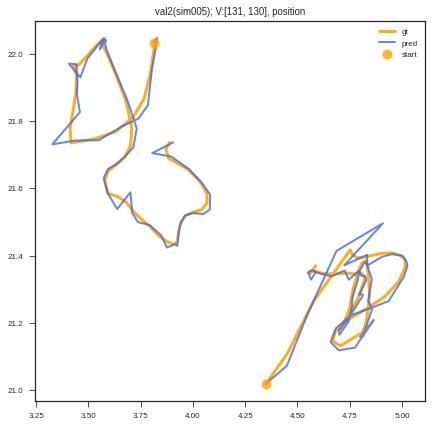

In [78]:
pos = model_results[dataset_k][mov_i]['targets']['pos']
pos_p = model_results[dataset_k][mov_i]['predictions']['pos']

e_st = model_results[dataset_k][mov_i]['edge_index'][:,k]
e_st_list = e_st.ravel().tolist()
plt.figure(figsize=[7,7])
plt.plot(pos[:,e_st_list,0],pos[:,e_st_list,1], '-', c='orange', lw=3, alpha=.9,label=['gt']+[None for k in range(len(e_st_list)-1)])
plt.plot(pos_p[:,e_st_list,0],pos_p[:,e_st_list,1], '-',c='royalblue', lw=2, alpha=.8, label=['pred']+[None for k in range(len(e_st_list)-1)]);

plt.plot(pos[0,e_st_list,0],pos[0,e_st_list,1], 'o', c='orange', ms=10, alpha=.8,label='start')
# for e_k in range(e_st.shape[1]):
#     plt.plot(pos[-1,e_st[:,e_k],0],pos[-1,e_st[:,e_k],1], '-', c='orange', lw=4, alpha=.5)
#     plt.plot(pos_p[-1,e_st[:,e_k],0],pos_p[-1,e_st[:,e_k],1], '-',c='navy', lw=4, alpha=.4);
plt.title(f'{dataset_k}({mov_i}); V:{e_st_list}, position')
# plt.xlim([340, 380])
# plt.ylim([240, 200])
# plt.axis(False)
plt.legend();